In [134]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
import datetime

In [2]:
#loading the dataset from Excel file
data = []
path = "IBM.xls"
with open(path, 'r') as csv_file:
    for row in csv.reader(csv_file):
        data.append(row)

In [3]:
#Loading the dataset to the pandas
df = pd.DataFrame(data[1:], columns = data[0])
df = df.set_index(df["Date"])
df = df.drop(columns="Date")
df=df.astype(float)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,186.729996,188.710007,186.000000,186.300003,134.881241,5646000.0
2012-01-04,185.570007,186.330002,184.940002,185.539993,134.330948,4346700.0
2012-01-05,184.809998,185.029999,183.100006,184.660004,133.693863,4463100.0
2012-01-06,184.389999,184.479996,182.309998,182.539993,132.158981,4897100.0
2012-01-09,182.199997,182.270004,180.270004,181.589996,131.471176,5201200.0


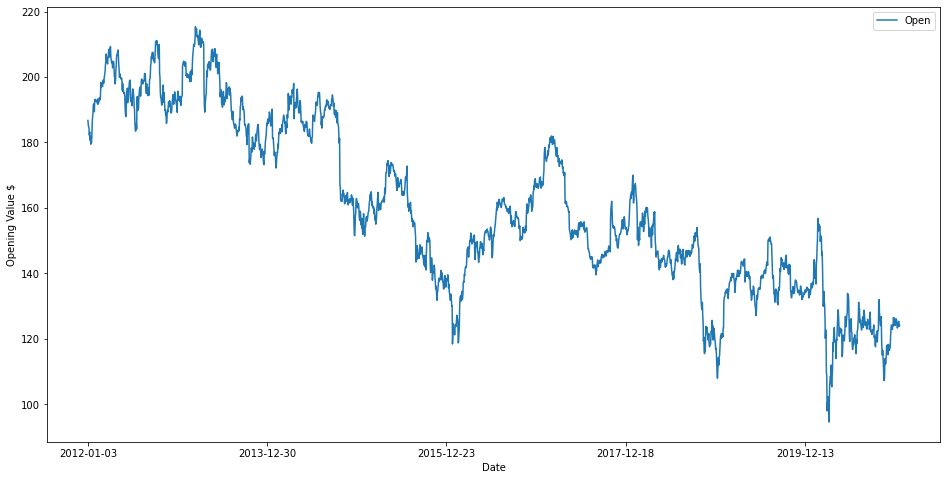

In [40]:
df.plot(y="Open", use_index=True, figsize=(16,8))
plt.title("")
plt.xlabel("Date", fontsize=10)
plt.ylabel("Opening Value $", fontsize=10)
plt.show()

In [5]:
#Filtering the dataset
data = df.filter(["Open"])
dataset = data.values
dataset = np.array(dataset)

In [6]:
#Scaling the dataset for the LSTM network to upgrade the efficiency
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.76279179],
       [0.75318764],
       [0.74689514],
       ...,
       [0.25459512],
       [0.24176191],
       [0.24523929]])

In [7]:
#Deviding the dataset to the training and testing datasets
training_dataset_length = int(len(dataset) * 0.8)
testing_dataset_length = int(len(dataset) - training_dataset_length)
training_dataset = scaled_data[:training_dataset_length]
testing_dataset = scaled_data[training_dataset_length-60:]

#Deviding the X_train and y_train
X_train = []
y_train = []
X_test = []
y_test = []

for i in range(60, len(training_dataset)):
    X_train.append(training_dataset[i-60:i, 0])
    y_train.append(training_dataset[i, 0])
for i in range(60, len(testing_dataset)):   
    X_test.append(testing_dataset[i-60:i, 0])

In [8]:
#Converting the list to numpy array and adding 3D
X_train, y_train, X_test = np.array(X_train), np.array(y_train), np.array(X_test)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print("Shape of X_train: ", X_train.shape, "\nShape of y_train: ", y_train.shape, "\nShape of X_test: ", X_test.shape)

Shape of X_train:  (1752, 60, 1) 
Shape of y_train:  (1752,) 
Shape of X_test:  (453, 60, 1)


In [9]:
def mymodel():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(64),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="Adam", 
              loss="mse")
    return model

In [10]:
model = mymodel()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1752 samples
1752/1752 [==============================] - 175s 100ms/sample - loss: 0.0039


In [20]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
predictions = np.reshape(predictions, predictions.shape[0])

In [90]:
train = data[:training_dataset_length]
valid = data[training_dataset_length:]
valid.insert(loc = 1, column = "Predictions", value = predictions)
valid.head()

,Open,Predictions
Date,,
2019-03-19,140.960007,137.492004
2019-03-20,140.529999,138.189468
2019-03-21,139.100006,138.908432
2019-03-22,140.970001,139.421463
2019-03-25,139.059998,139.889954


In [130]:
train_data = train["Open"].values
valid_data = valid["Open"].values
predic_data = valid["Predictions"].values
dates = train.index.values
pre_dates = valid.index.values

In [143]:
date = []
valid_date = []
for i in dates:
    date.append(datetime.datetime.strptime(i, '%Y-%m-%d'))
for i in pre_dates:
    valid_date.append(datetime.datetime.strptime(i, '%Y-%m-%d'))

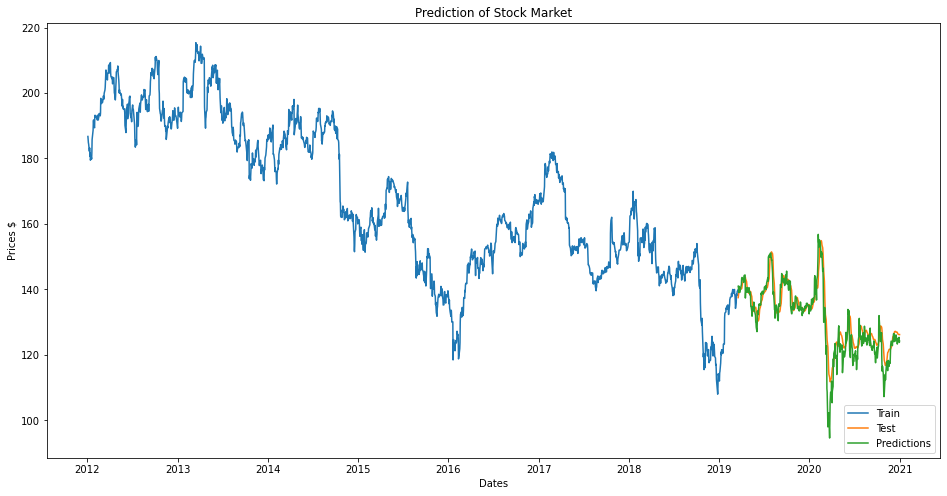

In [147]:
plt.figure(figsize=(16,8))
plt.title("Prediction of Stock Market")
plt.plot(date, train_data)
plt.xlabel("Dates")
plt.ylabel("Prices $")
plt.plot(valid_date, predic_data)
plt.plot(valid_date, valid_data)
plt.legend(["Train", "Test", "Predictions"], loc="lower right")
plt.show()